In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [30]:
model_path = "/home/aevans/transformer_ml/src/data/temp_df/20240331/Coastal/20240331_15:49_ml_output.parquet"

clim_div = 'Coastal'

full_df_path = '/home/aevans/transformer_ml/src/data/temp_df/20240331/Coastal/Coastal_BKLN.parquet'

In [31]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
nysm_cats_df = pd.read_csv(nysm_cats_path)
stations = nysm_cats_df[nysm_cats_df['climate_division_name']==clim_div]['stid'].unique()
stations

array(['BKLN', 'BRON', 'MANH', 'QUEE', 'SOUT', 'STAT', 'STON', 'WANT'],
      dtype=object)

In [32]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [33]:
df

,0_transformer_output,0_target,1_transformer_output,1_target,2_transformer_output,2_target,3_transformer_output,3_target,4_transformer_output,4_target,5_transformer_output,5_target,6_transformer_output,6_target,7_transformer_output,7_target
0,-0.114571,3.665487,-0.086147,1.019298,-0.126247,4.546518,-0.121728,4.621218,-0.026570,-0.151213,-0.116910,4.068203,-0.114521,5.326045,-0.102677,0.251918
1,-0.114576,9.498202,-0.086150,1.860273,-0.126250,2.214188,-0.121730,8.492919,-0.026516,-0.151213,-0.116916,7.364505,-0.114521,6.507898,-0.102691,0.561679
2,-0.114572,4.009320,-0.086150,2.684978,-0.126249,-0.069716,-0.121731,5.567189,-0.026464,-0.151213,-0.116910,3.395016,-0.114522,3.067863,-0.102679,0.684735
3,-0.114572,2.580140,-0.086154,3.245359,-0.126244,-0.146385,-0.121726,2.417940,-0.026539,-0.151213,-0.116909,1.700441,-0.114518,1.455478,-0.102679,0.506516
4,-0.114575,-0.124947,-0.086142,7.893467,-0.126251,-0.146385,-0.121728,-0.096670,-0.026511,-0.151213,-0.116910,-0.129546,-0.114527,-0.085151,-0.102686,0.302838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48733,-0.113955,-0.194779,-0.086537,-0.183147,-0.126052,-0.191037,-0.121564,-0.195621,-0.027266,-0.172214,-0.116699,-0.191929,-0.114481,-0.184600,-0.102594,-0.179732
48734,-0.113955,-0.194779,-0.086527,-0.183147,-0.126053,-0.191037,-0.121564,-0.195621,-0.027209,-0.172214,-0.116699,-0.191929,-0.114481,-0.184600,-0.102594,-0.179732
48735,-0.113955,-0.194779,-0.086536,-0.183147,-0.126051,-0.191037,-0.121564,-0.195621,-0.027195,-0.172214,-0.116698,-0.191929,-0.114481,-0.184600,-0.102593,-0.179732
48736,-0.113952,-0.194779,-0.086537,-0.183147,-0.126056,-0.191037,-0.121566,-0.195621,-0.027201,-0.172214,-0.116700,-0.191929,-0.114484,-0.184600,-0.102596,-0.179732


In [34]:
full_df = pd.read_parquet(full_df_path)

In [35]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [36]:
df_train, df_test = which_fold(full_df, 3)

In [37]:
df_test.iloc[0]

Timestamp('2021-08-06 18:00:00')

In [38]:
df_test.iloc[-1]

Timestamp('2022-09-18 01:00:00')

In [39]:
vt = full_df['valid_time'].to_list()
vt = vt[:int(len(df)-len(full_df))]
df['valid_time'] = vt

In [40]:
df = df[df['valid_time'] > datetime(2021, 9, 1, 0, 0, 0)]
df = df[df['valid_time'] < datetime(2021, 10, 30, 23, 0, 0)]
# df = df.drop(columns='valid_time')

In [41]:
def plot_outputs(df_out, clim_div, stations):
    import matplotlib.pyplot as plt 
    df_out = df_out.sort_index()
    fig, axs = plt.subplots(int(df_out.shape[1]/2), figsize=(21, 21), sharex=True, sharey=True)
    n = int(df_out.shape[1]/2)
    i = 0
    while n>i:
        axs[i].set_ylabel(f'{stations[i]}')
        axs[i].plot(df_out['valid_time'], df_out[f'{i}_target'], c="r", label="Target")
        axs[i].plot(df_out['valid_time'], df_out[f"{i}_transformer_output"], c="b", alpha=0.7, label="Transformer Output")
        
        print(f"Mean Absolute Difference of {stations[i]}: {abs(df_out[f'{i}_target'] - df_out[f'{i}_transformer_output']).mean()}")
        i+=1
    fig.suptitle(f"Transformer Output v Target", fontsize=28)

    axs[0].legend()
    plt.tight_layout()

Mean Absolute Difference of BKLN: 0.13959849435272398
Mean Absolute Difference of BRON: 0.1726780775122887
Mean Absolute Difference of MANH: 0.13197841133242502
Mean Absolute Difference of QUEE: 0.12957695639745914
Mean Absolute Difference of SOUT: 0.24676575949441887
Mean Absolute Difference of STAT: 0.14593581116207474
Mean Absolute Difference of STON: 0.16230082281739464
Mean Absolute Difference of WANT: 0.15905622339539918


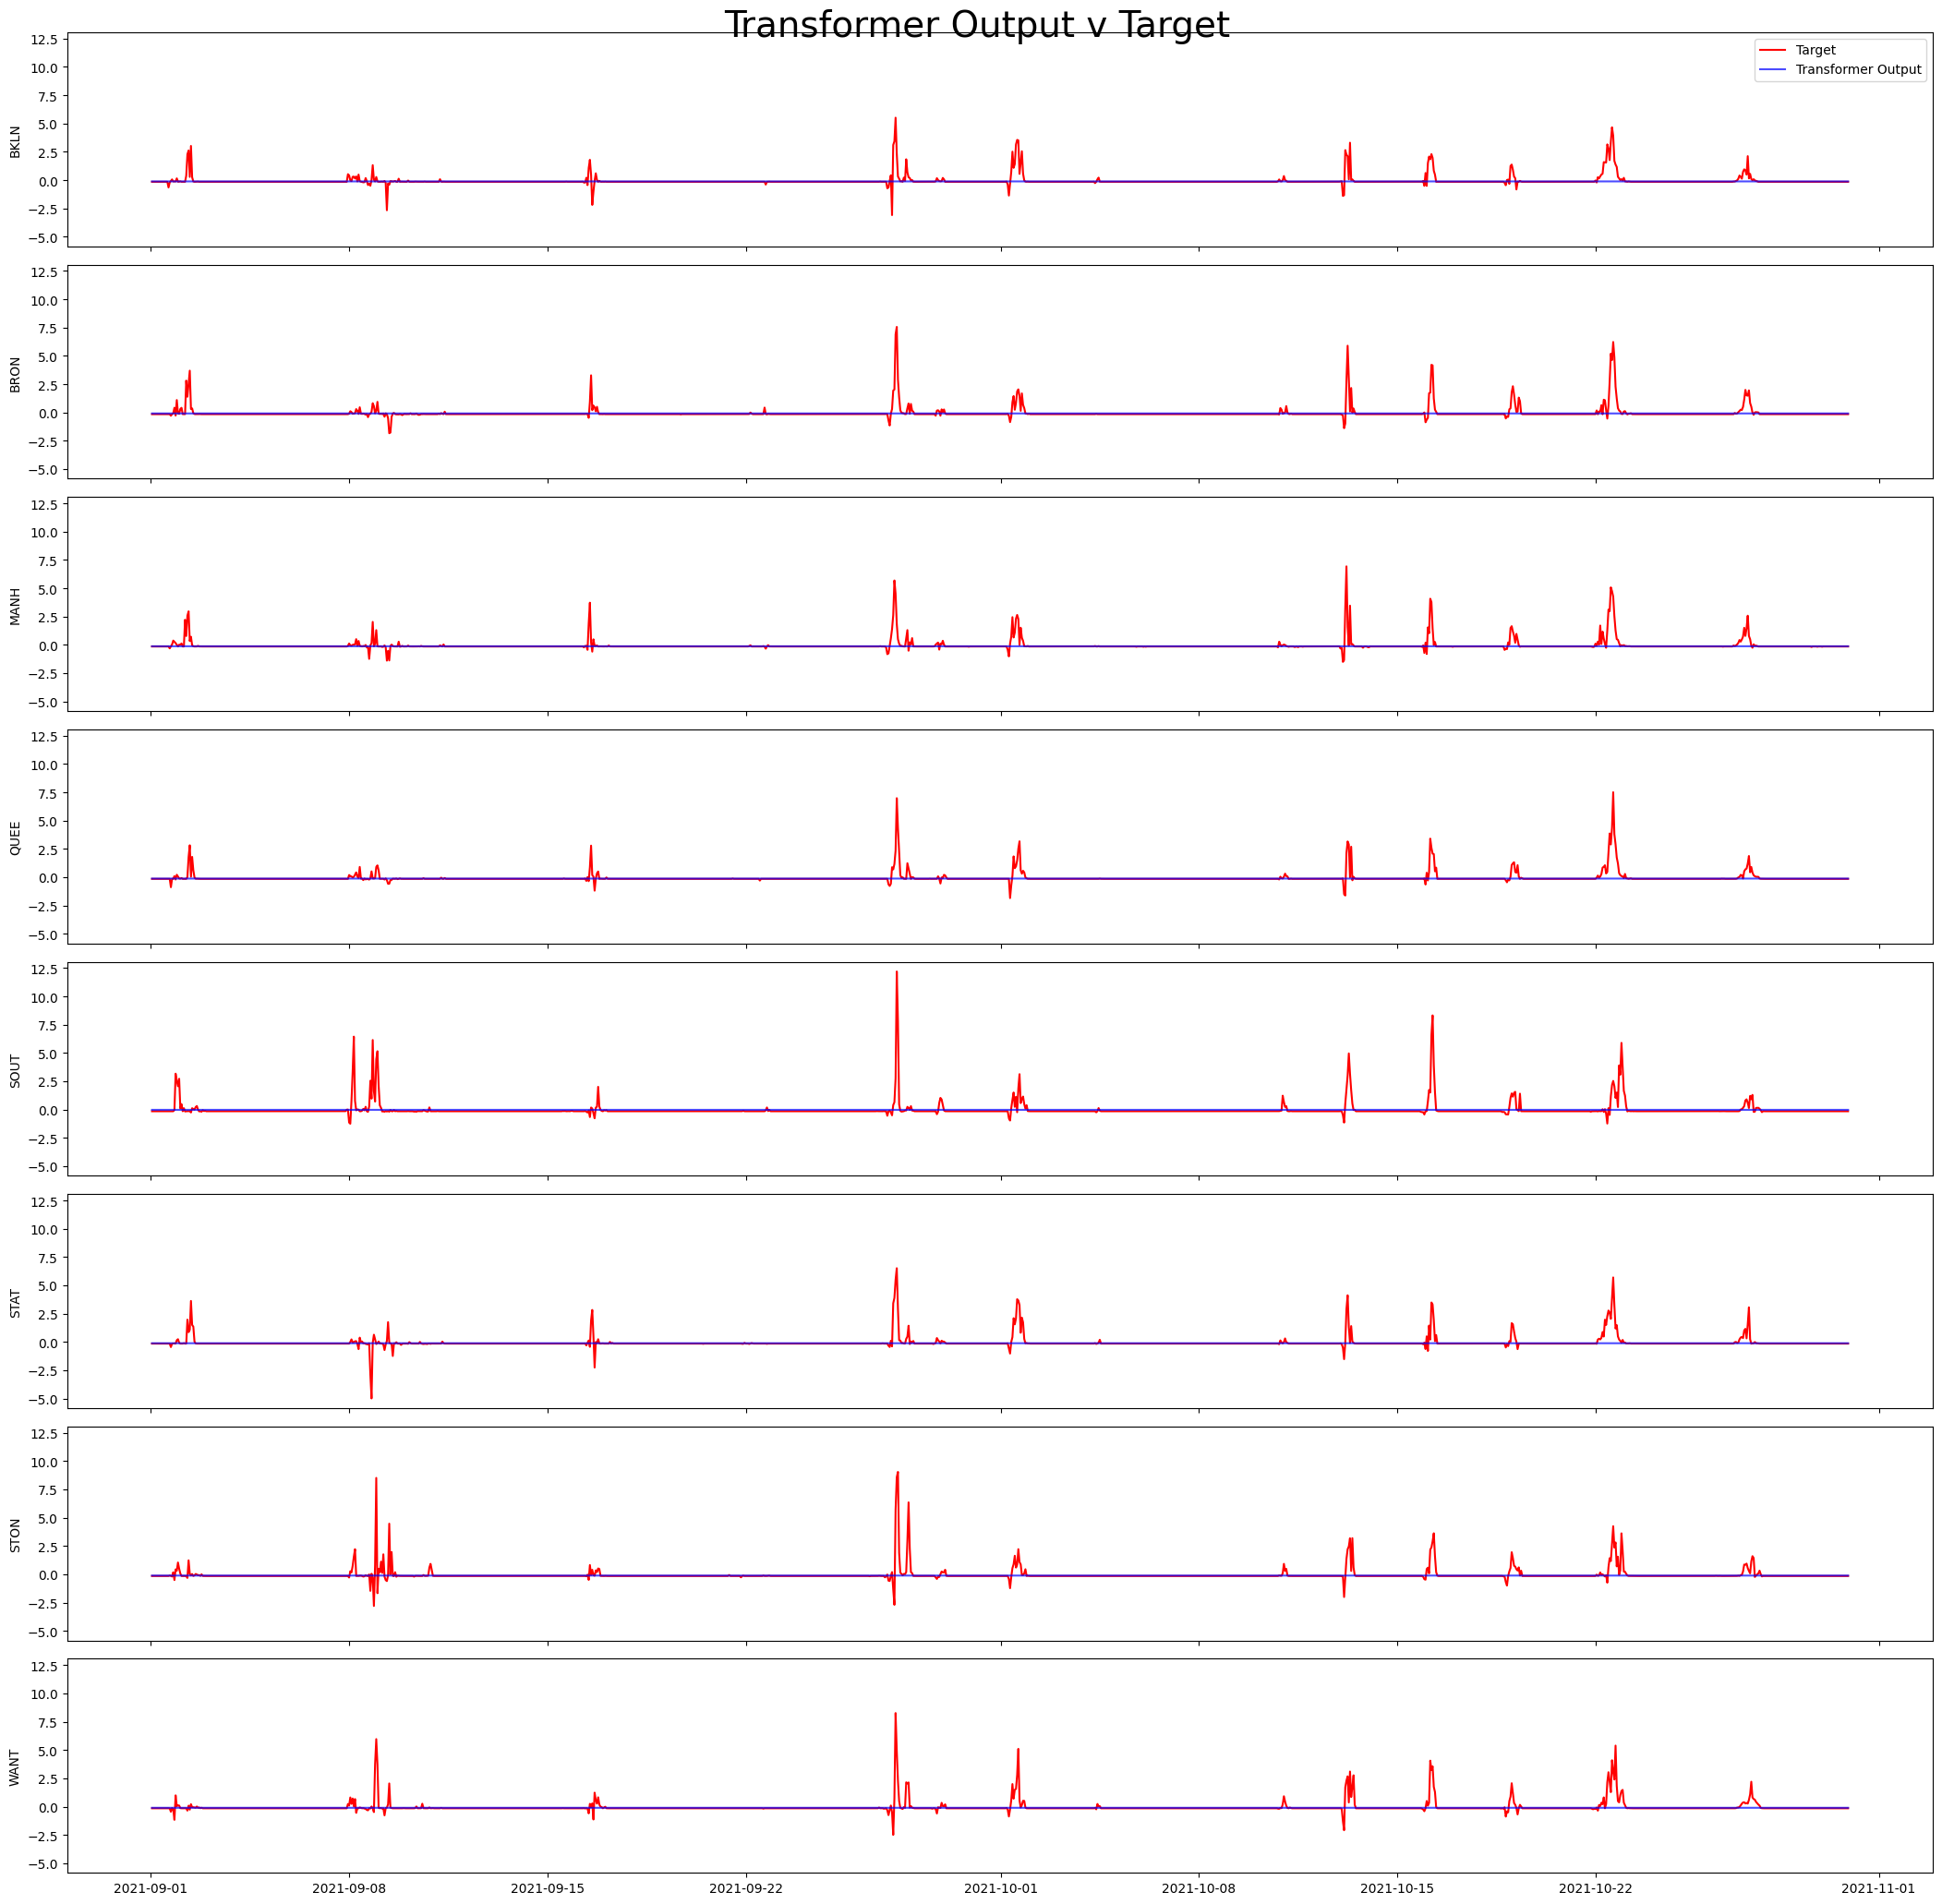

In [42]:
plot_outputs(df, clim_div, stations)